Import the libraries

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import pickle

Class Layer

In [105]:
class Layer:
    def __init__(self):
        # Initialize input and output attributes to None
        self.input = None
        self.output = None

    def forward_pass(self, input_data):
        # Forward pass method to compute the output given the input
        pass

    def backward_pass(self, error, learning_rate):
        # Backward pass method to compute the gradients and update the parameters
        pass


Linear Layer

In [106]:
class LinearLayer(Layer):
    def __init__(self, input_size, output_size):
        # Initializes the linear layer with random weights and biases.
        super().__init__()
        self.weights = np.random.rand(input_size, output_size) / np.sqrt(input_size)
        self.bias = np.random.rand(1, output_size) - 0.5

    def forward_pass(self, input_data):
        # Performs the forward pass computation of the linear layer.
        # Applies weights and biases to input data
        self.input_data = input_data
        output_data = np.add(np.matmul(input_data, self.weights), self.bias)
        return output_data

    def backward_pass(self, error, learning_rate):
        # Performs the backward pass computation of the linear layer.
        # Updates weights and biases based on the error and learning rate
        self.weights -= learning_rate * np.matmul(self.input_data.T, error)
        self.bias -= learning_rate * np.sum(error, axis=0)
        # Computes error to be propagated back
        input_error = np.matmul(error, self.weights.T)
        return input_error


Sigmoid Activation Layer

In [107]:
class SigmoidActivation(Layer):
    def __init__(self):
        # Initializes the Sigmoid activation layer.
        super().__init__()

    def forward_pass(self, input_data):
        # Performs the forward pass computation using Sigmoid activation.
        self.input_data = input_data
        output_data = 1 / (1 + np.exp(-input_data))
        return output_data

    def backward_pass(self, error):
        # Performs the backward pass computation for Sigmoid activation.
        # Compute derivative of Sigmoid activation
        sigmoid_derivative = self.input_data * (1 - self.input_data)
        # Propagate error backward
        input_error = sigmoid_derivative * error
        return input_error


Hyperbolic Tangent Activation Layer

In [108]:
class TanhActivation(Layer):
    def __init__(self):
        # Initializes the Tanh activation layer.
        super().__init__()

    def forward_pass(self, input_data):
        # Performs the forward pass computation using the Tanh activation function.
        # Compute Tanh activation and store the result
        self.activation_output = np.tanh(input_data)
        return self.activation_output

    def backward_pass(self, error):
        # Performs the backward pass computation for Tanh activation.
        # Compute derivative of Tanh activation
        tanh_derivative = 1 - self.activation_output ** 2
        # Propagate error backward
        input_error = tanh_derivative * error
        return input_error


Cross Entropy Loss

In [109]:
class CrossEntropyLoss(Layer):
    def __init__(self):
        # Initializes the Cross Entropy Loss layer.
        super().__init__()

    def forward_pass(self, predictions, targets):
        # Computes the forward pass of the Cross Entropy Loss.
        # Compute the Cross Entropy Loss
        loss = -targets * np.log(predictions)
        return loss

    def backward_pass(self, predictions, targets):
        # Computes the backward pass of the Cross Entropy Loss.
        # Compute the error for backpropagation
        error = targets - predictions
        return error


Soft Max Layer

In [110]:
class Softmax(Layer):
    def __init__(self):
        # Initializes the Softmax layer.
        super().__init__()

    def forward_pass(self, input_data):
        # Performs the forward pass computation using Softmax activation.
        # Subtracting maximum value for numerical stability
        subtracted_input = input_data - np.max(input_data)
        # Exponentiate the subtracted input
        exp_values = np.exp(subtracted_input)
        # Compute softmax probabilities
        self.softmax_output = exp_values / np.sum(exp_values, axis=0)
        return self.softmax_output

    def backward_pass(self, softmax_output, error):
        # Performs the backward pass computation for Softmax.
        # Compute the Jacobian matrix
        jacobian_matrix = - (softmax_output[:, :, np.newaxis] * softmax_output[:, np.newaxis, :])
        jacobian_matrix[:, range(softmax_output.shape[1]), range(softmax_output.shape[1])] += softmax_output
        # Compute the input error using the chain rule
        input_error = np.sum(error[:, np.newaxis, :] * jacobian_matrix, axis=2)
        return input_error


Activation Layer

In [111]:
class Activation(Layer):
    def __init__(self, activation_function, derivative_function):
        # Initializes the Activation layer with activation and derivative functions.
        super().__init__()
        self.activation_function = activation_function
        self.derivative_function = derivative_function

    def forward_pass(self, input_data):
        # Performs the forward pass computation using the activation function.
        # Store input data for backward pass
        self.input_data = input_data
        # Apply activation function
        output_data = self.activation_function(input_data)
        return output_data

    def backward_pass(self, error, learning_rate):
        # Performs the backward pass computation using the derivative of the activation function.
        # Compute derivative of activation function
        activation_derivative = self.derivative_function(self.input_data)
        # Compute error to be propagated back
        input_error = activation_derivative * error
        return input_error


In [112]:
def find_mse(predictions, targets):
    # Calculates the mean squared error (MSE) between predictions and targets.
    mse = np.mean((targets - predictions) ** 2)
    return mse

def find_gradient(predictions, targets):
    # Calculates the gradient of the mean squared error (MSE) with respect to predictions.
    gradient = 2 * (predictions - targets) / len(targets)
    return gradient


Sequential Layer

In [170]:
class Sequential(Layer):
    def __init__(self):
        # Initializes the Sequential model.
        self.layers = []

    def add_layer(self, new_layer):
        # Adds a new layer to the Sequential model.
        self.layers.append(new_layer)
        
    def set_loss_functions(self, loss_function, loss_gradient):
        # Sets the loss functions for the model.
        self.loss_function = loss_function
        self.loss_gradient = loss_gradient

    def predict(self, input_data):
        # Predicts the output for input data using the current model.
        predictions = []
        # Iterate over each input data point
        for data_point in input_data:
            output = data_point
            # Pass input through each layer in the model
            for layer in self.layers:
                output = layer.forward_pass(output)
            predictions.append(output)
        return predictions

    def fit(self, x_train, y_train, epochs, learning_rate):
        # Trains the model on the training data.
        fitted_errors = []
        # Iterate over each epoch
        for epoch in range(epochs):
            total_error = 0
            # Iterate over each training sample
            for x_sample, y_sample in zip(x_train, y_train):
                output = x_sample
                # Forward pass through each layer
                for layer in self.layers:
                    output = layer.forward_pass(output) 
                total_error += self.loss_function(y_sample, output)  # Compute error and accumulate
                error_gradient = self.loss_gradient(y_sample, output)  # Compute error gradient
                # Backward pass through each layer
                for layer in reversed(self.layers):
                    error_gradient = layer.backward_pass(error_gradient, learning_rate)
            total_error /= len(x_train)  # Compute average error
            fitted_errors.append(total_error)
            # Print progress
            if epoch % 1 == 0:
                print('Epoch %d --> Error = %f' % (epoch+1, total_error))
        return fitted_errors

    def save_model(self, file="neural_network_model.wts"):
        # Saves the model to a file.
        with open(file, mode="wb") as f:
            pickle.dump(self.retrieve_weights(), f)

    def load_model(self, file="neural_network_model.wts"):
        # Loads the model from a file.
        with open(file, mode="rb") as f:
            weights = pickle.load(f)
        return weights

    def retrieve_weights(self):
        # Retrieves the weights from the model.
        for layer in self.layers:
            if isinstance(layer, LinearLayer):
                self.weights = layer.weights
                return self.weights


XOR Problem Model with Sigmoid Activation Function

In [173]:
# Define input and output data
x_train = np.array([[[0,0]],[[0,1]],[[1,0]],[[1,1]]])
y_train = np.array([[[0]],[[1]],[[1]],[[0]]])

# Create a Sequential model
smodel = Sequential()

# Add layers to the Sequential model
smodel.add_layer(LinearLayer(2, 2))
s_model = SigmoidActivation()
smodel.add_layer(Activation(s_model.forward_pass, s_model.backward_pass))
smodel.add_layer(LinearLayer(2, 1))
smodel.add_layer(Activation(s_model.forward_pass, s_model.backward_pass))

# Set loss functions for the model
smodel.loss_function = lambda tar, pred: np.mean((tar-pred) ** 2)
smodel.loss_gradient = lambda tar, pred: 2 * np.mean(pred-tar)

# Train the model
fitted_errors = smodel.fit(x_train, y_train, epochs=100, learning_rate=0.1)

# Predict output using the trained model
sout = smodel.predict(x_train)
print("Predicted : ", sout)

# Apply threshold to predictions for classification
threshold = 0.5
spred = [int(p > threshold) for p in sout]
print(spred)

# Retrieve and save the optimized weights
smodel.retrieve_weights()
smodel.save_model()

# Load the optimized weights
optimized_weights = smodel.load_model()
print("Optimized weights:", optimized_weights)

# Calculate accuracy of the model
s_acc = accuracy_score([0, 1, 1, 0], spred)
print("Accuracy of this model: ", s_acc)


Epoch 1 --> Error = 0.270430
Epoch 2 --> Error = 0.268569
Epoch 3 --> Error = 0.266883
Epoch 4 --> Error = 0.265368
Epoch 5 --> Error = 0.264016
Epoch 6 --> Error = 0.262812
Epoch 7 --> Error = 0.261741
Epoch 8 --> Error = 0.260790
Epoch 9 --> Error = 0.259945
Epoch 10 --> Error = 0.259191
Epoch 11 --> Error = 0.258518
Epoch 12 --> Error = 0.257916
Epoch 13 --> Error = 0.257375
Epoch 14 --> Error = 0.256888
Epoch 15 --> Error = 0.256449
Epoch 16 --> Error = 0.256050
Epoch 17 --> Error = 0.255688
Epoch 18 --> Error = 0.255359
Epoch 19 --> Error = 0.255057
Epoch 20 --> Error = 0.254781
Epoch 21 --> Error = 0.254528
Epoch 22 --> Error = 0.254294
Epoch 23 --> Error = 0.254078
Epoch 24 --> Error = 0.253878
Epoch 25 --> Error = 0.253693
Epoch 26 --> Error = 0.253521
Epoch 27 --> Error = 0.253361
Epoch 28 --> Error = 0.253211
Epoch 29 --> Error = 0.253071
Epoch 30 --> Error = 0.252940
Epoch 31 --> Error = 0.252817
Epoch 32 --> Error = 0.252702
Epoch 33 --> Error = 0.252593
Epoch 34 --> Error 

C:\Users\Admin\AppData\Local\Temp\ipykernel_10212\2101612806.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  spred = [int(p > threshold) for p in sout]


XOR Problem Model with Hyperbolic Tangent Activation Function

In [176]:
# Define input and output data
x_train = np.array([[[0,0]],[[0,1]],[[1,0]],[[1,1]]])
y_train = np.array([[[0]],[[1]],[[1]],[[0]]])

# Create a Sequential model
tmodel = Sequential()

# Add layers to the Sequential model
tmodel.add_layer(LinearLayer(2, 2))
t_model = TanhActivation()
tmodel.add_layer(Activation(t_model.forward_pass, t_model.backward_pass))
tmodel.add_layer(LinearLayer(2, 1))
tmodel.add_layer(Activation(t_model.forward_pass, t_model.backward_pass))

# Set loss functions for the model
tmodel.loss_function = lambda tar, pred: np.mean((tar-pred) ** 2)
tmodel.loss_gradient = lambda tar, pred: 2 * np.mean(pred-tar)

# Train the model
fitted_errors = tmodel.fit(x_train, y_train, epochs=100, learning_rate=0.1)

# Predict output using the trained model
tout = tmodel.predict(x_train)
print("Predicted : ", tout)

# Apply threshold to predictions for classification
threshold = 0.5
tpred = [int(p > threshold) for p in tout]
print(tpred)

# Retrieve and save the optimized weights
tmodel.retrieve_weights()
tmodel.save_model()

# Load the optimized weights
optimized_weights = tmodel.load_model()
print("Optimized weights:", optimized_weights)

# Calculate accuracy of the model
t_acc = accuracy_score([0, 1, 1, 0], tpred)
print("Accuracy of this model: ", t_acc)


Epoch 1 --> Error = 0.280783
Epoch 2 --> Error = 0.277388
Epoch 3 --> Error = 0.274578
Epoch 4 --> Error = 0.272350
Epoch 5 --> Error = 0.270662
Epoch 6 --> Error = 0.269441
Epoch 7 --> Error = 0.268604
Epoch 8 --> Error = 0.268068
Epoch 9 --> Error = 0.267759
Epoch 10 --> Error = 0.267612
Epoch 11 --> Error = 0.267581
Epoch 12 --> Error = 0.267627
Epoch 13 --> Error = 0.267722
Epoch 14 --> Error = 0.267849
Epoch 15 --> Error = 0.267992
Epoch 16 --> Error = 0.268142
Epoch 17 --> Error = 0.268293
Epoch 18 --> Error = 0.268439
Epoch 19 --> Error = 0.268579
Epoch 20 --> Error = 0.268709
Epoch 21 --> Error = 0.268829
Epoch 22 --> Error = 0.268938
Epoch 23 --> Error = 0.269036
Epoch 24 --> Error = 0.269123
Epoch 25 --> Error = 0.269198
Epoch 26 --> Error = 0.269263
Epoch 27 --> Error = 0.269317
Epoch 28 --> Error = 0.269362
Epoch 29 --> Error = 0.269397
Epoch 30 --> Error = 0.269422
Epoch 31 --> Error = 0.269440
Epoch 32 --> Error = 0.269449
Epoch 33 --> Error = 0.269451
Epoch 34 --> Error 

C:\Users\Admin\AppData\Local\Temp\ipykernel_10212\2195196499.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  tpred = [int(p > threshold) for p in tout]


Handwritten Digit Recognition

In [ ]:
from keras.datasets import mnist
from keras.utils import np_utils

In [ ]:
# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [ ]:
# Split the training data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1)

In [ ]:
# Reshape training, validation, and test sets to have a single channel and flatten the images
x_train = x_train.reshape(x_train.shape[0], 1, 28*28)
x_test = x_test.reshape(x_test.shape[0], 1, 28*28)
x_val = x_val.reshape(x_val.shape[0], 1, 28*28)

# Convert data type to 'float64' and normalize pixel values to the range [0, 1]
x_train = x_train.astype('float64') / 255
x_test = x_test.astype('float64') / 255
x_val = x_val.astype('float64') / 255

# Convert labels to one-hot encoding using np_utils.to_categorical
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
y_val = np_utils.to_categorical(y_val)

In [ ]:
def calaccuracy(y, ypred):
    ypred_index = np.argmax(ypred, axis=1)  # Get the index of the maximum value along the second axis (axis=1) for both true and predicted labels
    y_index = np.argmax(y, axis=1)
    acc = np.sum(ypred_index == y_index).astype(np.float64) / len(y)  # Calculate the accuracy by comparing the indices of true and predicted labels
    return acc

In [ ]:
def calset(set):
    ss = []  # Initialize an empty list to store one-hot encoded labels
    for s in set:
        max_index = np.argmax(s)  # Find the index of the maximum value in the label
        cs = np.zeros(10)  # Create an array of zeros with length 10 (assuming there are 10 classes)
        cs[max_index] = 1  # Set the element at the maximum index to 1
        ss.append(cs)  # Append the one-hot encoded label to the list
    return np.array(ss)  # Convert the list of one-hot encoded labels to a numpy array

Model 1 on the training and testing dataset

In [ ]:
# Create a Sequential model
mnistmodel1 = Sequential()

# Define activation function
h1 = TanhActivation()

# Add layers to the Sequential model
mnistmodel1.add_layer(LinearLayer(28*28, 100))
mnistmodel1.add_layer(Activation(h1.forward_pass, h1.backward_pass))
mnistmodel1.add_layer(LinearLayer(100, 50))
mnistmodel1.add_layer(Activation(h1.forward_pass, h1.backward_pass))
mnistmodel1.add_layer(LinearLayer(50, 25))
mnistmodel1.add_layer(Activation(h1.forward_pass, h1.backward_pass))
mnistmodel1.add_layer(LinearLayer(25, 10))
mnistmodel1.add_layer(Activation(h1.forward_pass, h1.backward_pass))

epoch 1 --> error = 0.121498
epoch 2 --> error = 0.120499
epoch 3 --> error = 0.120507
epoch 4 --> error = 0.120510
epoch 5 --> error = 0.120512
epoch 6 --> error = 0.120513
epoch 7 --> error = 0.120514
epoch 8 --> error = 0.120514
epoch 9 --> error = 0.120515
epoch 10 --> error = 0.120515
Accuracy of mnist model 1 on training dataset:  0.09770370370370371


Text(0, 0.5, 'Loss')

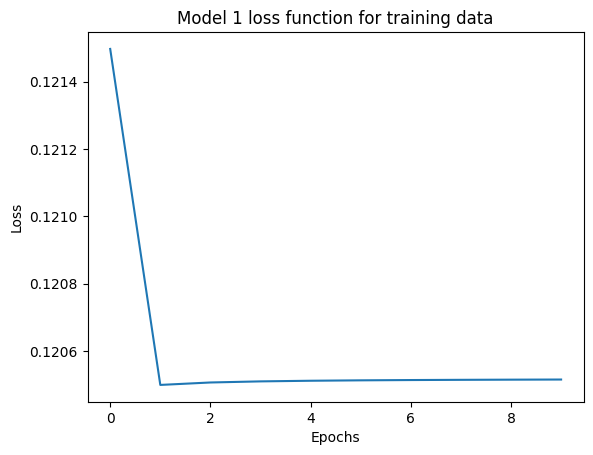

In [ ]:
# Set the loss functions for the model
mnistmodel1.set_loss_functions(findmse, findgradient)

# Train the model on the training dataset
loss1_train = mnistmodel1.fit(x_train, y_train, epoch=10, lr=0.1)

# Predict output for the training dataset
pred1 = mnistmodel1.predict(x_train)

# Convert predictions to one-hot encoded format
t1 = calset(pred1)

# Calculate accuracy of the model on the training dataset
accuracy1_train = calaccuracy(y_train, t1)
print("Accuracy of mnist model 1 on training dataset: ", accuracy1_train)

# Plot the loss function for the training dataset
plt.plot(loss1_train)
plt.title('Model 1 loss function for training data')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


epoch 1 --> error = 0.122992
epoch 2 --> error = 0.122989
epoch 3 --> error = 0.122989
epoch 4 --> error = 0.122989
epoch 5 --> error = 0.122989
Accuracy of mnsit model 1 on test dataset:  0.0958


Text(0, 0.5, 'Loss')

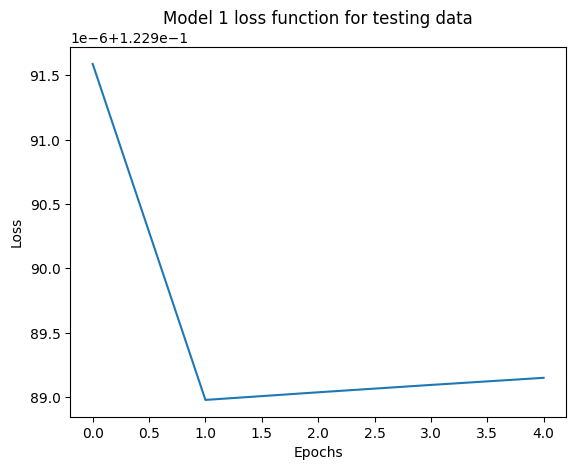

In [ ]:
# Set the loss functions for the model
mnistmodel1.set_loss_functions(findmse, findgradient)

# Train the model on the test dataset
loss1_test = mnistmodel1.fit(x_test, y_test, epoch=5, lr=0.1)

# Predict output for the test dataset
pred1 = mnistmodel1.predict(x_test)

# Convert predictions to one-hot encoded format
t1 = calset(pred1)

# Calculate accuracy of the model on the test dataset
accuracy1_test = calaccuracy(y_test, t1)
print("Accuracy of mnist model 1 on test dataset: ", accuracy1_test)

# Plot the loss function for the test dataset
plt.plot(loss1_test)
plt.title('Model 1 loss function for testing data')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

Model 2 on the training and testing dataset

In [ ]:
# Create a new Sequential model
mnistmodel2 = Sequential()

# Define activation function
h2 = TanhActivation()

# Add layers to the Sequential model
mnistmodel2.add_layer(LinearLayer(28*28, 150))
mnistmodel2.add_layer(Activation(h2.forward_pass, h2.backward_pass))
mnistmodel2.add_layer(LinearLayer(150, 75))
mnistmodel2.add_layer(Activation(h2.forward_pass, h2.backward_pass))
mnistmodel2.add_layer(LinearLayer(75, 10))
mnistmodel2.add_layer(Activation(h2.forward_pass, h2.backward_pass))

epoch 1 --> error = 0.235583
epoch 2 --> error = 0.097175
epoch 3 --> error = 0.093343
epoch 4 --> error = 0.086768
epoch 5 --> error = 0.086335
epoch 6 --> error = 0.086160
epoch 7 --> error = 0.085995
epoch 8 --> error = 0.077549
epoch 9 --> error = 0.067415
epoch 10 --> error = 0.066478
Accuracy of mnist model 2 on training dataset:  0.3921851851851852


Text(0, 0.5, 'Loss')

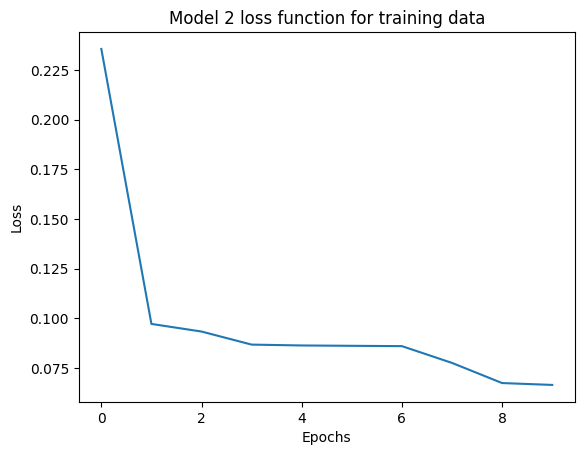

In [ ]:
# Set the loss functions for the model
mnistmodel2.set_loss_functions(findmse, findgradient)

# Train the model on the training dataset
loss2_train = mnistmodel2.fit(x_train, y_train, epoch=10, lr=0.01)

# Predict output for the training dataset
pred2 = mnistmodel2.predict(x_train)

# Convert predictions to one-hot encoded format
t2 = calset(pred2)

# Calculate accuracy of the model on the training dataset
accuracy2_train = calaccuracy(y_train, t2)
print("Accuracy of mnist model 2 on training dataset: ", accuracy2_train)

# Plot the loss function for the training dataset
plt.plot(loss2_train)
plt.title('Model 2 loss function for training data')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

epoch 1 --> error = 0.066611
epoch 2 --> error = 0.066515
epoch 3 --> error = 0.066438
epoch 4 --> error = 0.066374
epoch 5 --> error = 0.066318
Accuracy of mnsit model 2 on test dataset:  0.4173


Text(0, 0.5, 'Loss')

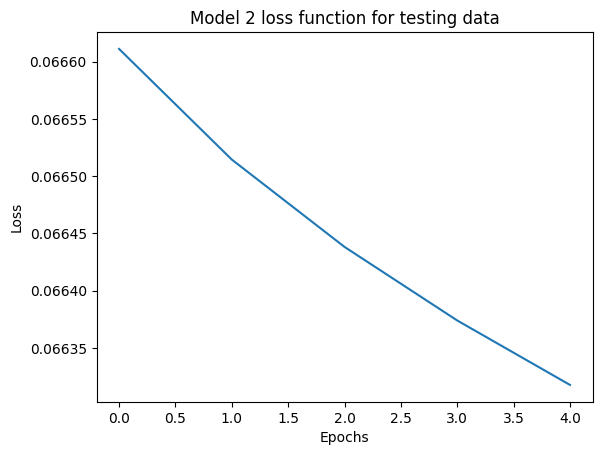

In [ ]:
# Set the loss functions for the model
mnistmodel2.set_loss_functions(findmse, findgradient)

# Train the model on the test dataset
loss2_test = mnistmodel2.fit(x_test, y_test, epoch=5, lr=0.01)

# Predict output for the test dataset
pred2 = mnistmodel2.predict(x_test)

# Convert predictions to one-hot encoded format
t2 = calset(pred2)

# Calculate accuracy of the model on the test dataset
accuracy2_test = calaccuracy(y_test, t2)
print("Accuracy of mnist model 2 on test dataset: ", accuracy2_test)

# Plot the loss function for the test dataset
plt.plot(loss2_test)
plt.title('Model 2 loss function for testing data')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

Model 3 on the training and testing dataset

In [ ]:
# Create a new Sequential model
mnistmodel3 = Sequential()

# Define activation function
h3 = TanhActivation()

# Add layers to the Sequential model
mnistmodel3.add_layer(LinearLayer(28*28, 20))
mnistmodel3.add_layer(Activation(h3.forward_pass, h3.backward_pass))
mnistmodel3.add_layer(LinearLayer(20, 10))
mnistmodel3.add_layer(Activation(h3.forward_pass, h3.backward_pass))

epoch 1 --> error = 0.027731
epoch 2 --> error = 0.026856
epoch 3 --> error = 0.026086
epoch 4 --> error = 0.025387
epoch 5 --> error = 0.024755
epoch 6 --> error = 0.024180
epoch 7 --> error = 0.023643
epoch 8 --> error = 0.023132
epoch 9 --> error = 0.022645
epoch 10 --> error = 0.022194
Accuracy of mnist model 3 on training dataset:  0.9035


Text(0, 0.5, 'Loss')

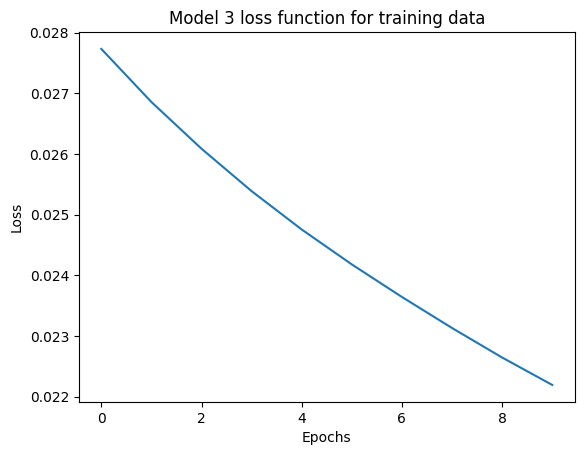

In [ ]:
# Set the loss functions for the model
mnistmodel3.set_loss_functions(findmse, findgradient)

# Train the model on the training dataset
loss3_train = mnistmodel3.fit(x_train, y_train, epoch=10, lr=0.001)

# Predict output for the training dataset
pred3 = mnistmodel3.predict(x_train)

# Convert predictions to one-hot encoded format
t3 = calset(pred3)

# Calculate accuracy of the model on the training dataset
accuracy3_train = calaccuracy(y_train, t3)
print("Accuracy of mnist model 3 on training dataset: ", accuracy3_train)

# Plot the loss function for the training dataset
plt.plot(loss3_train)
plt.title('Model 3 loss function for training data')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

epoch 1 --> error = 0.021131
epoch 2 --> error = 0.020955
epoch 3 --> error = 0.020807
epoch 4 --> error = 0.020673
epoch 5 --> error = 0.020551
Accuracy of mnsit model 3 on test dataset:  0.9133


Text(0, 0.5, 'Loss')

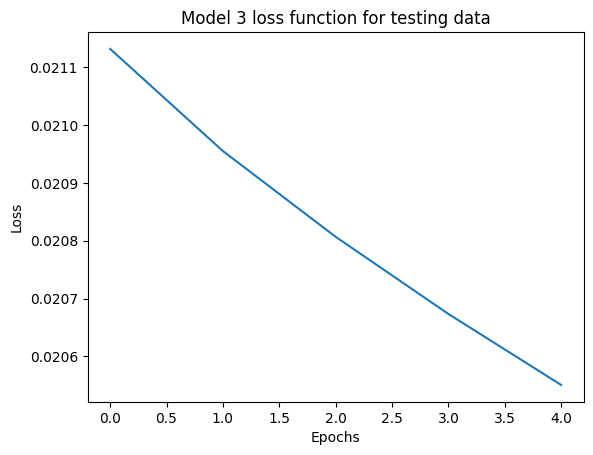

In [ ]:
# Set the loss functions for the model
mnistmodel3.set_loss_functions(findmse, findgradient)

# Train the model on the test dataset
loss3_test = mnistmodel3.fit(x_test, y_test, epoch=5, lr=0.001)

# Predict output for the test dataset
pred3 = mnistmodel3.predict(x_test)

# Convert predictions to one-hot encoded format
t3 = calset(pred3)

# Calculate accuracy of the model on the test dataset
accuracy3_test = calaccuracy(y_test, t3)
print("Accuracy of mnist model 3 on test dataset: ", accuracy3_test)

# Plot the loss function for the test dataset
plt.plot(loss3_test)
plt.title('Model 3 loss function for testing data')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()